# LDH cytotoxicity-vs-T2est

**Sensitivity of LDH cytotoxicity assay to the proliferation infection point estimated using the paired 24 h AO/DAPI % viability data.**

In [1]:
import numpy as np
import scipy.optimize as optim
import math
import os,sys
import pandas as pd
import copy
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as st
from scipy.stats import t
import random as rand

from sklearn.metrics import auc

import copy

In [2]:
def linear(x,a,b):
    return (a + b*x)

In [3]:
def nonlinear(x,a,b):
    return (np.exp(a + b*x))

In [4]:
data_folder = './data/LDHcytotoxicity'
os.chdir(data_folder)

**Read all LDH data and map inflection point from paired 24 h AO/DAPI % viability value.**

In [5]:
LDH24 = pd.read_csv('cytotoxicity_data-day1.csv')

tags = ['18','20','22','24']

weight1 = pd.Series([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.95])
colors1 = weight1.apply(lambda x: (0,0,0,x)).tolist()

all_data = {}

for tag in tags:
    all_data['Assay'+tag] = LDH24['Assay'+tag].to_numpy()
    all_data['T2-'+tag] = 85.77*np.power(LDH24['AODAPI'+tag].to_numpy()/100,-1.7)

cytos, t2s = [], []

for tag in tags:
    for a,b in zip(all_data['Assay'+tag],all_data['T2-'+tag]):
        cytos.append(a)
        t2s.append(b)   

In [6]:
dof = len(t2s) - 2
    
tinv = lambda p, df: abs(t.ppf(p/2,df))
ts = tinv(0.05,dof)

**Nonlinear regression analysis and estimation of confidence interval and prediction bounds.**

In [7]:
results = optim.curve_fit(nonlinear,cytos,t2s,absolute_sigma=False,full_output=True)

popt, pcov = results[0], results[1]

fitname = r'T2$_{\mathrm{est}}$ = exp(' + str(round(popt[0],3)) + '+' + str(round(popt[1],3)) +'%$C$)'

In [8]:
mean_cyto = np.linspace(0.9*np.min(cytos),1.15*np.max(cytos),250)
mean_t2 = nonlinear(mean_cyto,popt[0],popt[1])

In [9]:
residual = nonlinear(np.array(cytos),popt[0],popt[1]) - np.array(t2s)
norm_RSS = math.sqrt(np.dot(residual,residual)/(len(t2s)-2))

RSS_text = r's.d. = ' + str(round(norm_RSS,2)) + ' h'

In [10]:
n_samples = 10000

s_is, i_is = [], []

cit2_up = np.zeros(shape=mean_cyto.shape)
cit2_low = np.zeros(shape=mean_cyto.shape)

pbt2_up = np.zeros(shape=mean_cyto.shape)
pbt2_low = np.zeros(shape=mean_cyto.shape)

sigmat2_up = np.zeros(shape=mean_cyto.shape)
sigmat2_low = np.zeros(shape=mean_cyto.shape)

t2 = np.zeros(shape=mean_cyto.shape)
effective_sigma = np.zeros(shape=mean_cyto.shape)

for i in range(0,mean_cyto.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
    
    t2[i] = nonlinear(mean_cyto[i],popt[0],popt[1])
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(nonlinear(mean_cyto[i],a_sample,b_sample))
        
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
        
    pbt2_low[i], pbt2_up[i] = t2[i] - ci95, t2[i] + ci95
    
    cit2_low[i], cit2_up[i] = t2[i] - sigma*ts, t2[i] + sigma*ts
    
    sigmat2_low[i], sigmat2_up[i] = t2[i] - effective_sigma[i], t2[i] + effective_sigma[i]

Text(15, 80, 'T2$_{\\mathrm{est}}$ = exp(4.336+0.016%$C$)')

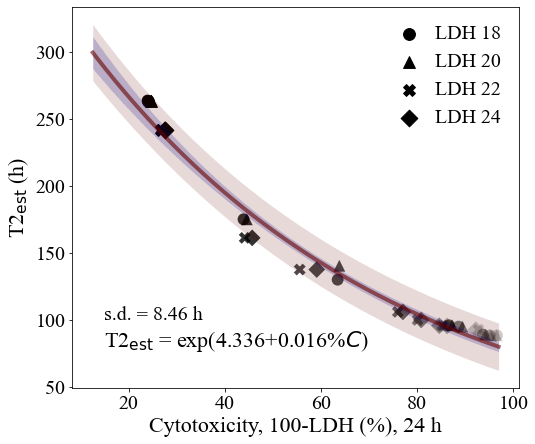

In [11]:
fig, axs = plt.subplots(figsize=(8,7))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

markers = {'18':'o','20':'^','22':'X','24':'D'}

for tag in tags:
    plt.scatter(100-all_data['Assay'+tag],all_data['T2-'+tag],marker=markers[tag],linewidth=0,s=140,c=colors1)
    
    plt.scatter(100-all_data['Assay'+tag][-1],all_data['T2-'+tag][-1],marker=markers[tag],s=140,c='black',label='LDH '+tag)
    
plt.xticks(size=20)
plt.yticks(size=20) 

plt.plot(100-mean_cyto,mean_t2,linewidth=4,color='#660000',alpha=0.6)#,label=fitname)

plt.fill_between(100-mean_cyto,pbt2_up,pbt2_low,alpha=0.15,color='#660000',linewidth=0.0)
plt.fill_between(100-mean_cyto,cit2_up,cit2_low,alpha=0.2,color='#000088',linewidth=0.0)

plt.legend(frameon=False,prop={'size': 20},markerscale=1.0,handlelength=1.0,loc='best')

plt.xlabel(r'Cytotoxicity, 100-LDH (%), 24 h',size=22)
plt.ylabel(r'T2$_{\mathrm{est}}$ (h)',size=22,rotation=90)

plt.text(15,100,RSS_text,fontsize=20)
plt.text(15,80,fitname,fontsize=22)

#plt.savefig('cytotoxicity-day1-v2-TH.png',dpi=300)

In [12]:
#test_t2s = [96,108,120,132,144,156,168,180,192,204,216,228,240,252,264]
test_t2s = [96,120,144,168,192,216,240,264]
#test_t2s = [96,144,192,240]
test_t2s.reverse()

cutoff_probs = {}
pdfs = {}
cdfs = {}

for k in test_t2s:
    cutoff_probs[k] = np.zeros(shape=mean_cyto.shape)
    pdfs[k] = np.zeros(shape=mean_cyto.shape)
    cdfs[k] = np.zeros(shape=mean_cyto.shape)
    
responses = np.zeros(shape=(len(test_t2s),mean_cyto.shape[0]))

j = 0

for k in test_t2s:
    for i in range(0,mean_cyto.shape[0]):
        cutoff_probs[k][i] = st.t.sf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        pdfs[k][i] = st.t.pdf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        
    pdfs[k] *= 1.0/np.sum(pdfs[k])
    
    x = copy.deepcopy(pdfs[k][::-1])
    cdfs[k] = np.round(np.array([np.sum(x[m:]) for m in range(0,pdfs[k].shape[0])]),3)
    
    responses[j,:] = pdfs[k]
    
    j += 1

Text(0.5, 0, '100$-$%$C$, 24 h')

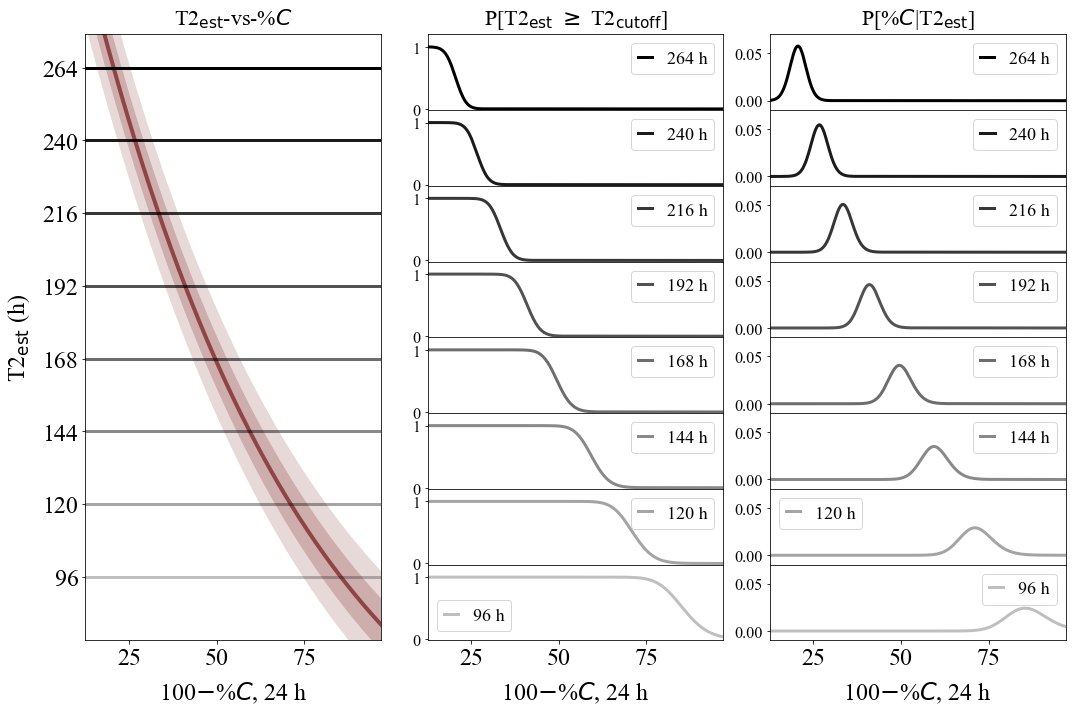

In [13]:
fig = plt.figure(tight_layout=True,figsize=(15,10))
gs = fig.add_gridspec(len(test_t2s),3, hspace=0)

ax = fig.add_subplot(gs[:,0])
ax.plot(100-mean_cyto,t2,linewidth=4,color='#660000',alpha=0.6,label=fitname)

ax.fill_between(100-mean_cyto,pbt2_up,pbt2_low,alpha=0.15,color='#660000',linewidth=0.0)
ax.fill_between(100-mean_cyto,sigmat2_up,sigmat2_low,alpha=0.2,color='#660000',linewidth=0.0)

ax.set_title(r'T2$_{\mathrm{est}}$-vs-%$C$',size=22,pad=10)

ax.tick_params(axis='both',labelsize=24)
ax.set_yticks(test_t2s)
ax.set_xlabel(r'100$-$%$C$, 24 h',size=24,labelpad=10)
ax.set_ylabel(r'T2$_{\mathrm{est}}$ (h)',size=24,rotation=90,labelpad=10)
ax.set_ylim(75,275)
ax.set_xlim(np.min(100-mean_cyto),np.max(100-mean_cyto))

for t in test_t2s:
    _alpha = 0.25 + 0.75*(t - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(100-mean_cyto,t*np.ones(shape=mean_cyto.shape[0]),color='black',lw=3,alpha=_alpha)
    
for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,1])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(100-mean_cyto,cutoff_probs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    ax.tick_params(axis='y',labelsize=12)
    ax.set_ylim(-0.02,1.2)
    ax.set_xlim(np.min(100-mean_cyto),np.max(100-mean_cyto))
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title(r'P[T2$_{\mathrm{est}}$ $\geq$ T2$_{\mathrm{cutoff}}$]',size=22,pad=10)
        
ax.set_xlabel(r'100$-$%$C$, 24 h',size=24,labelpad=10)
    
for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,2])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(100-mean_cyto,pdfs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    ax.tick_params(axis='y',labelsize=12)
    #ax.set_ylim(-0.02,1.2)
    ax.set_xlim(np.min(100-mean_cyto),np.max(100-mean_cyto))
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.set_ylim(-0.01,0.07)
    
    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title('P[%$C$|T2$_{\mathrm{est}}$]',size=22,pad=10)
          
ax.set_xlabel(r'100$-$%$C$, 24 h',size=24,labelpad=10)

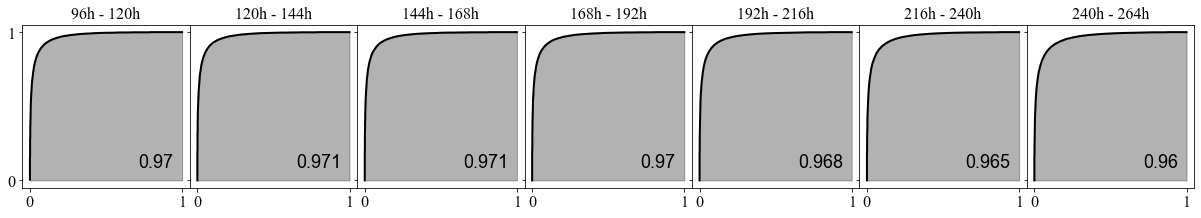

In [14]:
wd = 3

l = int((len(test_t2s)-1)*wd)

fig = plt.figure(figsize=(l,wd))
gs = fig.add_gridspec(ncols=len(test_t2s)-1, nrows=1, wspace=0)

axs = gs.subplots(sharex=True,sharey=True)

all_aucs = []

test_t2s = test_t2s[::-1]

wf = open('auc_summary.csv','w')
print('Time interval,AUC',file=wf)

for k in range(0,len(test_t2s)-1):  
    dx = copy.deepcopy(cdfs[test_t2s[k]][::-1])
    dy = copy.deepcopy(cdfs[test_t2s[k+1]][::-1])
    
    all_aucs.append(auc(dy,dx))
    
    label_text = str(round(all_aucs[-1],3))
    
    axs[k].plot(cdfs[test_t2s[k+1]],cdfs[test_t2s[k]],lw=2,color='black',label=label_text)
    axs[k].fill_between(cdfs[test_t2s[k+1]],0,cdfs[test_t2s[k]],color='black',alpha=0.3)#,label=str(test_t2s[k])+' h',alpha=_alpha)
    axs[k].set_xticks((0,1))
    axs[k].set_yticks((0,1))
    axs[k].tick_params(axis='both',labelsize=16)
    axs[k].legend(frameon=False,prop={'size': 18,'family':'Arial'},markerscale=1.0,handlelength=0.0,loc='lower right')
    axs[k].set_title(str(test_t2s[k])+'h - '+str(test_t2s[k+1])+'h',fontsize=16)
    
    output_string = str(test_t2s[k+1])+'h - '+str(test_t2s[k])+'h'
    output_string += ',' + label_text
    
    print(output_string,file=wf)
    
wf.close()

In [15]:
LDH0 = pd.read_csv('cytotoxicity_data-day0.csv')

tags = ['17','19','21','23']

weight1 = pd.Series([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.95])
colors1 = weight1.apply(lambda x: (0,0,0,x)).tolist()

In [16]:
all_data = {}

for tag in tags:
    all_data['Assay'+tag] = LDH0['Assay'+tag].to_numpy()
    all_data['T2-'+tag] = 85.77*np.power(LDH0['AODAPI'+tag].to_numpy()/100,-1.7)

In [17]:
cytos, t2s = [], []

for tag in tags:
    for a,b in zip(all_data['Assay'+tag],all_data['T2-'+tag]):
        cytos.append(a)
        t2s.append(b) 

In [18]:
results = optim.curve_fit(linear,cytos,t2s,absolute_sigma=False,full_output=True)

popt, pcov = results[0], results[1]

p_std = np.sqrt(np.diag(pcov))

fitname = r'T2$_{\mathrm{est}}$ = ' + str(round(popt[0],2)) + '+' + str(round(popt[1],2)) +'%$C$'

In [19]:
mean_cyto = np.linspace(np.min(cytos),np.max(cytos),50)
mean_t2 = linear(mean_cyto,popt[0],popt[1])

In [20]:
residual = linear(np.array(cytos),popt[0],popt[1]) - np.array(t2s)

norm_RSS = math.sqrt(np.dot(residual,residual)/(len(t2s)-2))

print(norm_RSS)

RSS_text = r's.d. = ' + str(round(norm_RSS,2)) + ' h'

45.01553502351084


In [21]:
result = st.linregress(np.array(cytos),t2s,alternative='two-sided')
print(result)

r_text = r'R$^2 = ' + str(round(result.rvalue**2,3)) + '$'

LinregressResult(slope=18.739469338030542, intercept=-23.327390771236196, rvalue=0.5835731831758544, pvalue=0.0004549994945882279, stderr=4.760907551904148, intercept_stderr=39.48775011266707)


In [22]:
n_samples = 10000

s_is, i_is = [], []

t2_up = np.zeros(shape=mean_cyto.shape)
t2_low = np.zeros(shape=mean_cyto.shape)

rt2_up = np.zeros(shape=mean_cyto.shape)
rt2_low = np.zeros(shape=mean_cyto.shape)

effective_sigma = np.zeros(shape=mean_cyto.shape)

for i in range(0,mean_cyto.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(linear(mean_cyto[i],a_sample,b_sample))
        
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
        
    t2_low[i], t2_up[i] = mean_t2[i] - ci95, mean_t2[i] + ci95
    
    rt2_low[i], rt2_up[i] = mean_t2[i] - sigma*ts, mean_t2[i] + sigma*ts

Text(91, 220, 'T2$_{\\mathrm{est}}$ = -23.33+18.74%$C$')

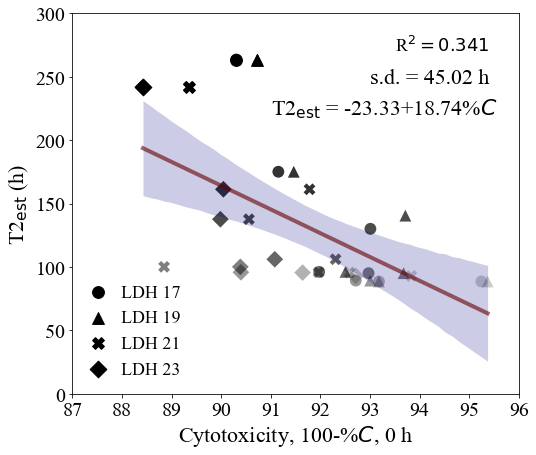

In [23]:
fig, axs = plt.subplots(figsize=(8,7))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

markers = {'17':'o','19':'^','21':'X','23':'D'}

for tag in tags:
    plt.scatter(100-all_data['Assay'+tag],all_data['T2-'+tag],marker=markers[tag],linewidth=0,s=140,c=colors1)
    
    plt.scatter(100-all_data['Assay'+tag][-1],all_data['T2-'+tag][-1],marker=markers[tag],s=140,c='black',label='LDH '+tag)
    
plt.plot(100-mean_cyto,mean_t2,linewidth=4,color='#660000',alpha=0.6)#,label=fitname)

plt.xticks(size=20)
plt.yticks(size=20) 

plt.xlim(87,96)

plt.fill_between(100-mean_cyto,rt2_up,rt2_low,alpha=0.2,color='#000088',linewidth=0.0)

plt.legend(frameon=False,prop={'size': 18},markerscale=1.0,handlelength=1.0,loc='lower left')

plt.xlabel(r'Cytotoxicity, 100-%$C$, 0 h',size=22)
plt.ylabel(r'T2$_{\mathrm{est}}$ (h)',size=22,rotation=90)
plt.text(93.5,270,r_text,fontsize=18)

plt.ylim(0,300)

plt.text(93,245,RSS_text,fontsize=22)

plt.text(91,220,fitname,fontsize=22)